In [210]:
!pip install tree-sitter-python tree-sitter autopep8 sentence_transformers

# Diversity analysis

In [211]:
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform, euclidean
from scipy.sparse.csgraph import minimum_spanning_tree
from math import log

# Define a function to get embeddings
def get_embedding(code, model, tokenizer, device):
    inputs = tokenizer.encode(code, return_tensors="pt").to(device)
    with torch.no_grad():
        embedding = model(inputs)[0].cpu().numpy()
    return embedding.reshape(1, -1)


def compute_cosine_similarity(embeddings):
    return cosine_similarity(embeddings)


def cluster_nodes(similarity_matrix, threshold=0.95):
    # Convert similarity matrix to distance matrix
    distance_matrix = 1 - similarity_matrix
    distance_matrix = np.clip(distance_matrix, 0, None)

    # Use hierarchical clustering
    condensed_distance_matrix = squareform(distance_matrix)
    Z = linkage(condensed_distance_matrix, method='complete')

    clusters = fcluster(Z, t=1-threshold, criterion='distance')

    # Collect nodes into clusters
    node_clusters = {}
    for node, cluster_id in enumerate(clusters):
        if cluster_id not in node_clusters:
            node_clusters[cluster_id] = []
        node_clusters[cluster_id].append(node)

    return list(node_clusters.values())


def calculate_shannon_diversity(clusters, total_nodes):
    proportions = [len(cluster) / total_nodes for cluster in clusters]
    shannon_index = -sum(p * log(p) for p in proportions if p > 0)
    return shannon_index


def shannon_diversity(embeddings, threshold):
    embeddings_2d = np.vstack(embeddings)

    # Compute similarity matrix
    similarity_matrix = compute_cosine_similarity(embeddings_2d)
    np.fill_diagonal(similarity_matrix, 1)
    #print(similarity_matrix)

    # Cluster nodes with a similarity threshold
    clusters = cluster_nodes(similarity_matrix, threshold)

    # Calculate Shannon Diversity Index
    total_nodes = len(embeddings)
    shannon_diversity_index = calculate_shannon_diversity(clusters, total_nodes)

    print("Clusters:", clusters)
    print("Shannon Diversity Index:", shannon_diversity_index)
    return shannon_diversity_index


def total_diversity(embeddings):
    embeddings_1d = np.vstack([emb.flatten() for emb in embeddings])  # Ensure 1D embeddings

    # Compute the distance matrix
    n = len(embeddings_1d)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            distance = euclidean(embeddings_1d[i], embeddings_1d[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    # Find the Minimum Spanning Tree (MST)
    mst = minimum_spanning_tree(distance_matrix).toarray()

    # Calculate the diversity index
    mst_distances = mst[mst != 0]
    total_distance = np.sum(mst_distances)

    proportions = mst_distances / total_distance
    diversity_index = -np.sum(proportions * np.log(proportions))

    print(f"CDI: {diversity_index}")
    return diversity_index

# Model and tokenizer setup
checkpoint = "Salesforce/codet5p-110m-embedding"
device = "cpu"  # Use "cuda" if you have a GPU
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)
model = AutoModel.from_pretrained(checkpoint, trust_remote_code=True).to(device)

def get_static(code_snippets, threshold):
    # Get embeddings for all code snippets
    embeddings = [get_embedding(code, model, tokenizer, device) for code in code_snippets]

    shannon_diversity_index = shannon_diversity(embeddings, threshold=threshold)
    CID = total_diversity(embeddings)
    return shannon_diversity_index, CID


# Pre-process Log Data

##  Population encoding

In [212]:
import os
import autopep8
import tempfile
import json
import re

import tree_sitter_python as tspython
from tree_sitter import Language, Parser

PY_LANGUAGE = Language(tspython.language())
parser = Parser(PY_LANGUAGE)

def format_python_code(code_str):
    # Write the code string to a temporary file
    with tempfile.NamedTemporaryFile('w', delete=False, suffix='.py') as temp_file:
        temp_file.write(code_str)
        temp_filename = temp_file.name

    # Format the file using autopep8
    autopep8_args = ['--in-place', '--aggressive', '--aggressive', temp_filename]
    autopep8.fix_file(temp_filename, options=autopep8.parse_args(autopep8_args))

    # Read the formatted code from the file
    with open(temp_filename, 'r') as temp_file:
        formatted_code = temp_file.read()

    return formatted_code

def remove_comments_and_docstrings(code):
    tree = parser.parse(bytes(code, "utf8"))
    root_node = tree.root_node

    lines = code.split('\n')
    to_remove = []

    def is_comment(node):
        return node.type == 'comment'

    def is_docstring(node):
        return (node.type == 'string' and
                (node.parent.type in ['expression_statement', 'module']))

    def traverse(node):
        if is_comment(node):
            to_remove.append((node.start_point, node.end_point))
        elif is_docstring(node):
            to_remove.append((node.start_point, node.end_point))
        for child in node.children:
            traverse(child)

    traverse(root_node)

    for start, end in reversed(to_remove):
        start_row, start_col = start
        end_row, end_col = end
        if start_row == end_row:
            lines[start_row] = lines[start_row][:start_col] + lines[start_row][end_col:]
        else:
            lines[start_row] = lines[start_row][:start_col]
            for row in range(start_row + 1, end_row):
                lines[row] = ''
            lines[end_row] = lines[end_row][end_col:]

    cleaned_lines = [line for line in lines if line.strip() != '']

    return '\n'.join(cleaned_lines)

## Utils function

In [213]:
def read_all_files_in_folder(folder_path, framework_name, parsed_data):
    if 'funsearch' in framework_name:
        folder_path = os.path.join(folder_path, 'samples')
    files = os.listdir(folder_path)
    lstcode = dict()

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        file_name_without_ext = os.path.splitext(file_name)[0]

        if ('hsevo' in framework_name or 'reevo' in framework_name) and ('_response' in file_name_without_ext or '_hs' in file_name_without_ext) and '_prompt' not in file_name_without_ext and 'objs_log_' not in file_name_without_ext:
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                    if '.txt_stdout' not in file_name_without_ext:
                        lstcode[file_name_without_ext] = content.replace('```python', '').replace('```', '')
                    elif '.txt_stdout' in file_name_without_ext and "[*] Average:" not in content:
                        file_name_without_ext = os.path.splitext(file_name_without_ext)[0]
                        lstcode.pop(file_name_without_ext)
                    #print(f'Content of {file_name}:\n{content}\n')
            except Exception as e:
                print(f'Could not read {file_name}: {e}')
        if 'funsearch' in framework_name:
            id_sample = file_name_without_ext.split('_')[1]

            if(int(id_sample) <= 330):
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        content = file.read()
                        content = json.loads(content)
                        if content['score']:
                            lstcode[file_name_without_ext] = content['function']
                            excess = (-content['score'] - l1_bound) / l1_bound * 100
                            parsed_data[int(id_sample)] = parsed_data[int(id_sample)] + (excess,)
                except Exception as e:
                    print(f'Could not read {file_name}: {e}')

    return lstcode

def parse_log(log_string):
  best_obj_pattern = re.compile(r"Best obj: (-?[\d\.]+)")
  tokens_pattern = re.compile(r"prompt_tokens = (\d+), completion_tokens = (\d+)")


  best_objs = best_obj_pattern.findall(log_string)
  tokens_matches = tokens_pattern.findall(log_string)

  results = []
  for i in range(max(len(best_objs), len(tokens_matches))):
      prompt_tokens = int(tokens_matches[i][0])
      completion_tokens = int(tokens_matches[i][1])
      total_tokens = prompt_tokens + completion_tokens
      try:
          best_obj = float(best_objs[i])
      except:
          best_obj = None

      if best_obj is not None:
        results.append((total_tokens, best_obj))
      else:
        results.append((total_tokens, ))

  return results

In [214]:
def create_sets_from_data(data, group_size=10):
    result = []
    min_second = float('inf')
    for i in range(0, len(data), group_size):
        group = data[i:i+group_size]
        max_first = max(item[0] for item in group)

        # Update the minimum value for the second position, considering all elements from the start to the current group
        for item in data[:i+len(group)]:
            if len(item) > 1:  # Check if there's a second position
                min_second = min(min_second, item[1])
        result.append((max_first, min_second))

    return result

def create_sets_from_data_eoh(parsed_data, num_init, obj_eoh):
    num_gen = len(obj_eoh)
    # Step 1: Group the first `num_init` elements and get the max value of this group
    first_group = max(parsed_data[:num_init])[0]

    # Step 2: Calculate the number of elements in each later group
    remaining_elements = len(parsed_data) - num_init
    group_size = remaining_elements // num_gen

    # Step 3: Initialize the list to store the result
    result = [(first_group, 0)]

    # Step 4: Group the remaining elements and get the max value of each group
    for i in range(num_gen):
        start_index = num_init + i * group_size
        end_index = start_index + group_size
        group = parsed_data[start_index:end_index]
        max_value = max(group)[0]
        result.append((max_value, obj_eoh[i]*100))

    return result

def get_max_obj_eoh(folder_path):
    lst_obj_eoh = []
    folder_path += "/pops_best"
    files = os.listdir(folder_path)

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                content = json.loads(content)
                lst_obj_eoh.append(content['objective'])
        except Exception as e:
            print(f'Could not read {file_name}: {e}')
    return lst_obj_eoh


def get_init_eoh(folder_path):
    lstcode = dict()
    init_logs = folder_path + "/pops/population_generation_0.json"
    with open(init_logs, 'r', encoding='utf-8') as file:
        content = file.read()
        content = json.loads(content)
        for idx, data in enumerate(content):
            if data['objective']:
                name_idv = "pop_0_off" + str(idx) + "_i0"
                lstcode[name_idv] = data['code']
    return lstcode

def eoh_preprocess(folder_path, parsed_data):
    # List all files in the folder
    lstcode = get_init_eoh(folder_path)

    folder_path += "/history"
    files = os.listdir(folder_path)

    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        file_name_without_ext = os.path.splitext(file_name)[0]

        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                content = json.loads(content)
                if content['offspring']['objective']:
                    lstcode[file_name_without_ext] = content['offspring']['code']
        except Exception as e:
            print(f'Could not read {file_name}: {e}')

    return lstcode

# Diversity calculator

In [215]:
log_run = {
        "name": "reevo-qd",
        "path": "outputs/main/reevo-qd_tsp_aco_2025-04-21_08-28-49"
}

f = open(log_run["path"] + '/main.log', "r")
data = f.read().split('\n')
f.close()
raw_string = ''
for idl in range(len(data)):
  if "hsevo" in log_run["name"] or "reevo" in log_run["name"]:
    if 'Best obj:' in data[idl]:
      raw_string += data[idl] + '\n' + data[idl+1] + '\n'
  elif "funsearch" in log_run["name"] or "eoh" in log_run["name"]:
    match = re.search(r"l1_bound:\s*([\d.]+)", data[0])
    if match:
      l1_bound = float(match.group(1))
      raw_string = '\n'.join(data[1:])
    else:
      raw_string = '\n'.join(data)



if "eoh" in log_run["name"]:
    lstcode = eoh_preprocess(log_run["path"], parsed_data)
    lst_init_eoh = get_init_eoh(log_run["path"])
    obj_eoh = get_max_obj_eoh(log_run["path"])
    parsed_data = create_sets_from_data_eoh(parsed_data, len(lst_init_eoh), obj_eoh)
elif "funsearch" in log_run["name"]:
    parsed_data = create_sets_from_data(parsed_data, 20)
else:
    parsed_data = parse_log(raw_string)

lstcode = read_all_files_in_folder(log_run["path"], log_run["name"], parsed_data)
for name, code in lstcode.items():
    # 1. Format code following PEP8
    formatted_code = format_python_code(code)

    # 2. Remove comments and docstrings in code
    cleaned_code = remove_comments_and_docstrings(formatted_code)
    lstcode[name] = cleaned_code

In [216]:
from collections import defaultdict

def group_names(lstcode, framework_name, base = 20):
    grouped_lists = defaultdict(list)

    # Regular expression patterns
    pattern_hsevo = re.compile(r'problem_iter(\d+)')
    pattern_reevo = re.compile(r'problem_iter(\d+)')
    pattern_funsearch = re.compile(r'samples_(\d+)')
    pattern_eoh = re.compile(r'pop_(\d+)')

    for name in lstcode.keys():
        log_run = lstcode[name]

        if "hsevo" in framework_name:
            match = pattern_reevo.match(name)
            if match:
                i = int(match.group(1))
                grouped_lists[i].append(name)
        elif "reevo" in framework_name:
            match = pattern_reevo.match(name)
            if match:
                i = int(match.group(1))
                grouped_lists[i].append(name)
        elif "funsearch" in framework_name:
            match = pattern_funsearch.match(name)
            if match:
                i = int(match.group(1)) - 1
                group_key = i // base
                grouped_lists[group_key].append(name)
        elif "eoh" in framework_name:
            match = pattern_eoh.match(name)
            if match:
                i = int(match.group(1))
                grouped_lists[i].append(name)

    for key in sorted(grouped_lists.keys()):
        print(f"List for group {key}:", grouped_lists[key])
    print("---------------\n\n")

    return grouped_lists

if "eoh" in log_run["name"]:
    grouped_lists = group_names(lstcode, "eoh")
elif "funsearch" in log_run["name"]:
    grouped_lists = group_names(lstcode, "funsearch", 20)
elif "hsevo" in log_run["name"]:
    grouped_lists = group_names(lstcode, "hsevo")
elif "reevo" in log_run["name"]:
    grouped_lists = group_names(lstcode, "reevo")
else:
    print("Group list error!")

SWDI_lst = []
CDI_lst = []

lst_pop = []

for key in sorted(grouped_lists.keys()):
    print(f"List for i group {key}:", grouped_lists[key])
    code_snippets = [lstcode[name] for name in grouped_lists[key]]
    lst_pop.extend(code_snippets)
    a,b = get_static(lst_pop, 0.95)
    print(key)
    print(parsed_data)
    parsed_data[key] = parsed_data[key] + (a, b,)
    SWDI_lst.append(a)
    CDI_lst.append(b)
    print("---------------\n")

print("SWDI:", SWDI_lst)
print("CDI:", CDI_lst)

List for group 1: ['problem_iter1_response0', 'problem_iter1_response1', 'problem_iter1_response10', 'problem_iter1_response11', 'problem_iter1_response12', 'problem_iter1_response13', 'problem_iter1_response14', 'problem_iter1_response15', 'problem_iter1_response16', 'problem_iter1_response17', 'problem_iter1_response18', 'problem_iter1_response19', 'problem_iter1_response2', 'problem_iter1_response20', 'problem_iter1_response21', 'problem_iter1_response22', 'problem_iter1_response23', 'problem_iter1_response24', 'problem_iter1_response25', 'problem_iter1_response26', 'problem_iter1_response27', 'problem_iter1_response28', 'problem_iter1_response29', 'problem_iter1_response3', 'problem_iter1_response4', 'problem_iter1_response5', 'problem_iter1_response6', 'problem_iter1_response7', 'problem_iter1_response8', 'problem_iter1_response9']
List for group 2: ['problem_iter2_response0', 'problem_iter2_response1', 'problem_iter2_response2', 'problem_iter2_response3', 'problem_iter2_response4

Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors


Clusters: [[0, 3, 4, 5, 7, 8, 15, 17, 18, 22, 25, 27], [1, 6, 14, 19, 24], [2], [9, 13, 21], [10, 26, 28], [11], [12], [16], [20, 29], [23]]
Shannon Diversity Index: 1.8730627999036535
CDI: 3.3382438246945663
1
[(0, 6.611106028447585), (886, 5.937175508448438), (32871, 5.873822907288655), (34571, 5.873822907288655), (65418, 5.873822907288655), (67347, 5.873822907288655), (100694, 5.873822907288655), (102454, 5.873822907288655), (134167, 5.873822907288655), (136082, 5.873822907288655), (168003, 5.873822907288655), (169708, 5.873822907288655)]
---------------

List for i group 2: ['problem_iter2_response0', 'problem_iter2_response1', 'problem_iter2_response2', 'problem_iter2_response3', 'problem_iter2_response4', 'problem_iter2_response5', 'problem_iter2_response6', 'problem_iter2_response7', 'problem_iter2_response8', 'problem_iter2_response9']
Clusters: [[0, 3, 4, 5, 7, 8, 15, 17, 18, 22, 25, 27, 31, 32, 37], [1, 6, 14, 19, 24, 30], [2, 33], [9, 13, 21], [10, 26, 28, 36], [11, 39], [12

In [217]:
parsed_data

[(0, 6.611106028447585),
 (886, 5.937175508448438, 1.8730627999036535, 3.3382438246945663),
 (32871, 5.873822907288655, 1.9625459927922047, 3.585317203208456),
 (34571, 5.873822907288655, 1.9595616193357537, 3.714773409106451),
 (65418, 5.873822907288655, 1.8635235311561251, 3.905362697940923),
 (67347, 5.873822907288655, 2.2120498159169824, 3.9941473922319344),
 (100694, 5.873822907288655, 2.3062457591490335, 4.129358009194016),
 (102454, 5.873822907288655, 2.4307862302362793, 4.202807113453408),
 (134167, 5.873822907288655, 2.453009036740496, 4.314505619957936),
 (136082, 5.873822907288655, 2.4625937544382523, 4.3764801235271875),
 (168003, 5.873822907288655, 2.3351180450380955, 4.469734587796839),
 (169708, 5.873822907288655, 2.4376670639291724, 4.5230027417027845)]

In [218]:
def find_nearest_best_obj(results, step=25000):
    results.sort(key=lambda x: x[0])  # Sort by total_tokens
    step_tokens = 0
    nearest_objs = []

    while step_tokens <= results[-1][0]:  # Iterate until the maximum total_tokens
        nearest = min(results, key=lambda x: abs(x[0] - step_tokens))
        # Extract the last 3 elements from the nearest tuple
        nearest_objs.append((step_tokens, abs(nearest[-3]), nearest[-2], nearest[-1]))
        step_tokens += step

    return nearest_objs

def fill_missing_elements(data):
    if data[0][0] == 0:
        data[0] = (data[0][0], data[0][1], 0, 0)
    for i in range(1, len(data)):
        if len(data[i]) == 2:
            data[i] = (
                data[i][0],
                data[i][1],
                data[i-1][2],
                data[i-1][3]
            )
    return data

parsed_data = fill_missing_elements(parsed_data)
nearest_objs = find_nearest_best_obj(parsed_data, 25000)
nearest_objs

[(0, 6.611106028447585, 0, 0),
 (25000, 5.873822907288655, 1.9625459927922047, 3.585317203208456),
 (50000, 5.873822907288655, 1.8635235311561251, 3.905362697940923),
 (75000, 5.873822907288655, 2.2120498159169824, 3.9941473922319344),
 (100000, 5.873822907288655, 2.3062457591490335, 4.129358009194016),
 (125000, 5.873822907288655, 2.453009036740496, 4.314505619957936),
 (150000, 5.873822907288655, 2.4625937544382523, 4.3764801235271875)]

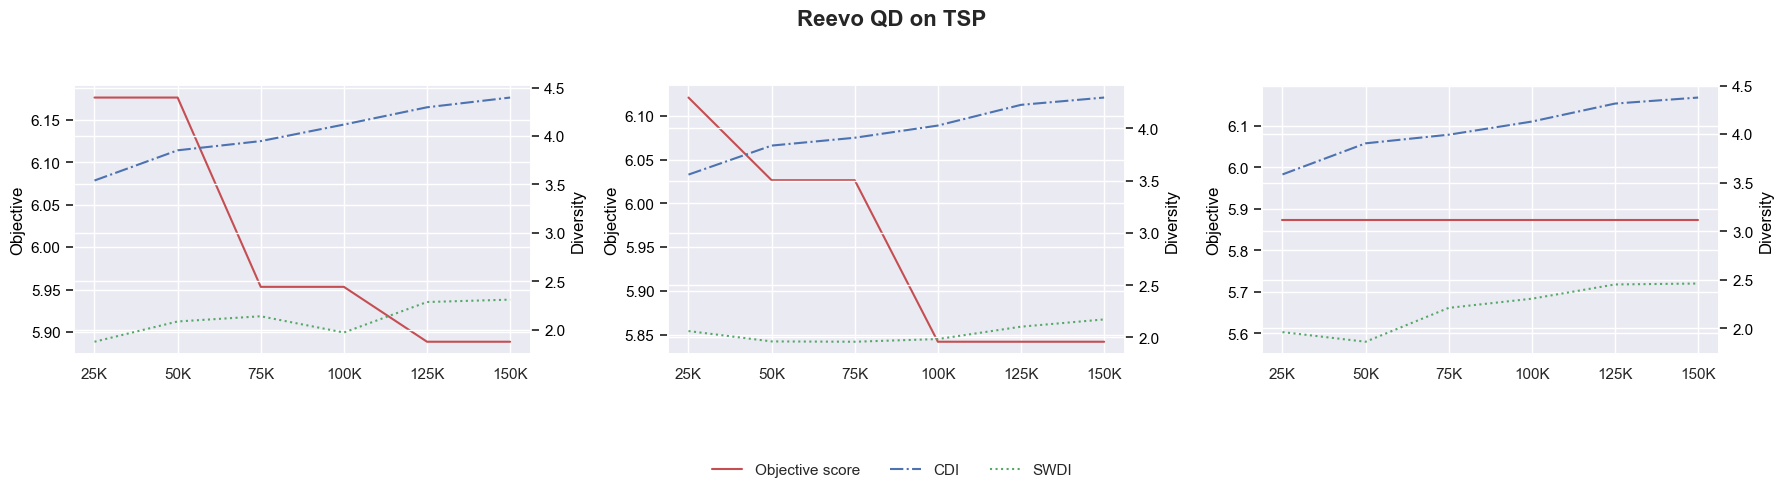

In [221]:
import matplotlib.pyplot as plt

data_1 = [
 (25000, 6.176186154508582, 1.8779212240656333, 3.5408367285317435),
 (50000, 6.176186154508582, 2.086965185491544, 3.852337051176502),
 (75000, 5.953191254409847, 2.140646304985391, 3.9474024601744135),
 (100000, 5.953191254409847, 1.9727599872326302, 4.117926952595031),
 (125000, 5.888536572475294, 2.2876288315435334, 4.296181070007584),
 (150000, 5.888536572475294, 2.312160516455742, 4.396651816657529)]

data_2 = [
 (25000, 6.121078348604702, 2.061230364669838, 3.558293066767667),
 (50000, 6.026511194020268, 1.9620822835246994, 3.8359380266512666),
 (75000, 6.026511194020268, 1.959093049233081, 3.910895061401504),
 (100000, 5.841732593054792, 1.9845654958260797, 4.027571831478771),
 (125000, 5.841732593054792, 2.1031262996898272, 4.225740260536289),
 (150000, 5.841732593054792, 2.172532867684628, 4.295523361602713)]

data_3 = [
 (25000, 5.873822907288655, 1.9625459927922047, 3.585317203208456),
 (50000, 5.873822907288655, 1.8635235311561251, 3.905362697940923),
 (75000, 5.873822907288655, 2.2120498159169824, 3.9941473922319344),
 (100000, 5.873822907288655, 2.3062457591490335, 4.129358009194016),
 (125000, 5.873822907288655, 2.453009036740496, 4.314505619957936),
 (150000, 5.873822907288655, 2.4625937544382523, 4.3764801235271875)]

tokens1, obj1, swdi1, cdi1 = zip(*data_1)
tokens2, obj2, swdi2, cdi2 = zip(*data_2)
tokens3, obj3, swdi3, cdi3 = zip(*data_3)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), sharey=False)

data = [(tokens1, obj1, swdi1, cdi1), (tokens2, obj2, swdi2, cdi2), (tokens3, obj3, swdi3, cdi3)]

for i in range(3):
    tokens, obj, swdi, cdi = data[i]
    ax1 = axs[i]

    l1, = ax1.plot(tokens, obj, 'r-', label='Objective score')
    ax1.set_ylabel("Objective", color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2 = ax1.twinx()
    l2, = ax2.plot(tokens, cdi, 'b-.', label='CDI')
    l3, = ax2.plot(tokens, swdi, 'g:', label='SWDI')
    ax2.set_ylabel("Diversity", color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    if i == 0:
        global_lines = [l1, l2, l3]
        global_labels = [l.get_label() for l in global_lines]

for i, ax in enumerate(axs):
    xticks = data[i][0]
    ax.set_xticks(xticks)
    xtick_labels = [f"{x//1000}K" for x in xticks]
    ax.set_xticklabels(xtick_labels)

fig.suptitle("Reevo QD on TSP", fontsize=16, fontweight='bold')

fig.legend(global_lines, global_labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.1), frameon=False)

plt.tight_layout(rect=[0, 0.2, 1, 0.95])

plt.savefig("reevo_qd_tsp.png", dpi=300)
plt.show()